In [1]:
import torch
from tqdm import tqdm
import numpy as np

from transformers import AutoTokenizer
from model_loading import get_weight_by_name


In [23]:
# "meta-llama/Llama-3.1-70B", "meta-llama/Llama-3.1-8B"
# "Qwen/Qwen2.5-0.5B-Instruct", "Qwen/Qwen2.5-1.5B-Instruct", "Qwen/Qwen2.5-3B-Instruct", "Qwen/Qwen2.5-7B-Instruct"
# "Qwen/Qwen2.5-14B-Instruct", "Qwen/Qwen2.5-32B-Instruct", "Qwen/Qwen2.5-72B-Instruct"
model_name = "Qwen/Qwen2.5-72B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
embeddings = get_weight_by_name(model_name, "head")
embeddings = embeddings.cuda()
# embeddings = torch.randn_like(embeddings)
embeddings.requires_grad = False

Fetching 47 files:   0%|          | 0/47 [00:00<?, ?it/s]

In [24]:
start = 0
top_k = 1
end = len(embeddings)
batch_size = 5000
batches = [
    range(i, min(i + batch_size, end)) for i in range(start, end, batch_size)
]
query_matrix = embeddings
second_ratios = []

for batch_idx, batch in enumerate(tqdm(batches)):
    batch_array = torch.tensor(list(batch), device=embeddings.device)
    X = query_matrix[batch_array]
    w = (X @ embeddings.T)

    # Get self-similarity scores efficiently using the batch indices
    batch_indices = torch.arange(len(batch_array), device=embeddings.device)
    self_scores = (w[batch_indices, batch_array]).clone()
    # Set self-similarity to a very low value
    w[batch_indices, batch_array] = -1e9
    scores, indices = torch.topk(w, k=top_k, dim=-1)
    ratio = (scores[:,0]/self_scores).cpu().float().numpy()
    second_ratios.append(ratio)

second_ratios = np.concatenate(second_ratios)

100%|██████████| 31/31 [00:02<00:00, 11.98it/s]


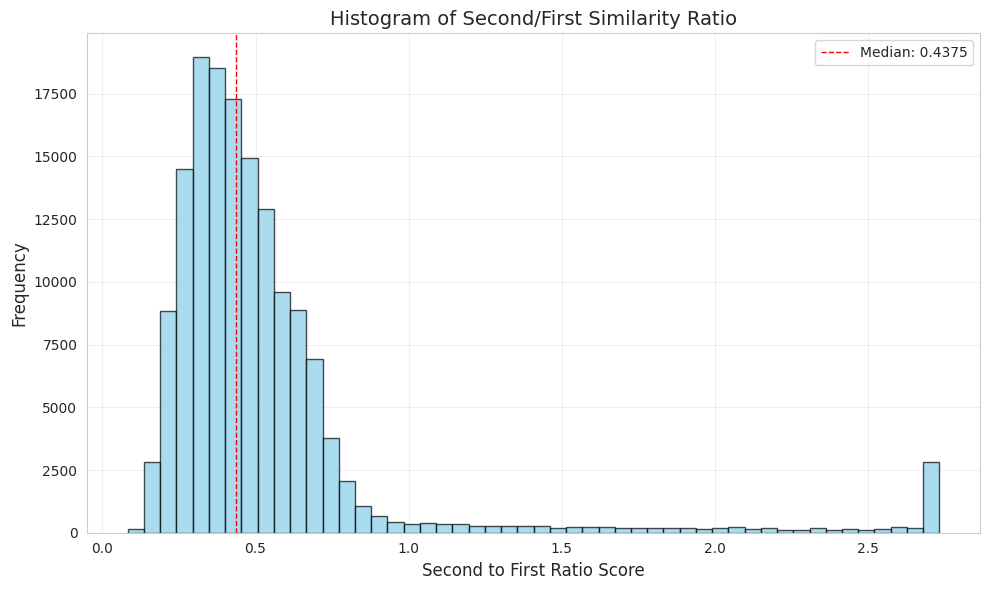

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(second_ratios, bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.xlabel('Second to First Ratio Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Second/First Similarity Ratio', fontsize=14)
plt.grid(alpha=0.3)
mean_ratio = np.median(second_ratios)
plt.axvline(mean_ratio, color='red', linestyle='dashed', linewidth=1, label=f'Median: {mean_ratio:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
sum(second_ratios>0.9)

10461